In [119]:
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom as pyd
import SimpleITK as sk
import math
import numpy as np
from numpy import savetxt
import torch
import torchio as tio
import itk
import os

In [2]:
class DICOM_reader:
    def __init__(self):
        self.file_path = ""
        self.CT_images = []
    
    def set_path(self, path):
        self.file_path = Path(path)
    
    def extract_images(self):
        file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(self.file_path))
        file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(self.file_path), file_ids[0])
        series_reader = sk.ImageSeriesReader()
        series_reader.SetFileNames(file_names)
        image_data = series_reader.Execute()
        self.CT_images = sk.GetArrayFromImage(image_data)
                
    def visualize(self, images, if_all, idx=None):
        if if_all:
            idx = list(range(len(images)))
        num1 = math.ceil(math.sqrt(len(idx)))
        num2 = math.floor(math.sqrt(len(idx)))
        num1 = num1+1 if num1*num2<len(idx) else num1
        fig, axis = plt.subplots(num2, num1, figsize=(20,20))
        slice_counter = 0
        if len(idx)==1:
            axis.imshow(images[idx[slice_counter]], cmap="gray")
        else:
            if num2>1:
                for i in range(num2):
                    for j in range(num1):
                        if slice_counter<len(idx):
                            axis[i][j].imshow(images[idx[slice_counter]], cmap="gray")
                            slice_counter+=1
                        else:
                            break
            else:
                for i in range(num1):
                    axis[i].imshow(images[idx[slice_counter]], cmap="gray")
                    slice_counter+=1
                                
    def get_images(self):
        # self.CT_images = [np.expand_dims(np.array(image.astype("int32")),axis=0) for image in self.CT_images]
        return self.CT_images

In [49]:
file_path = "/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209/"
file_ids = sk.ImageSeriesReader.GetGDCMSeriesIDs(str(file_path))
file_names = sk.ImageSeriesReader.GetGDCMSeriesFileNames(str(file_path), file_ids[0])
series_reader = sk.ImageSeriesReader()
series_reader.SetFileNames(file_names)
image_data = series_reader.Execute()
CT_images = sk.GetArrayFromImage(image_data)

In [87]:
image_data.GetMetaData('3004|000E')

RuntimeError: Exception thrown in SimpleITK Image_GetMetaData: /tmp/SimpleITK-build/ITK/Modules/Core/Common/src/itkMetaDataDictionary.cxx:77:
ITK ERROR: Key '3004|000E' does not exist 

In [53]:
CT_images.shape*image_data.GetNumberOfComponentsPerPixel()

(1, 99, 100, 191)

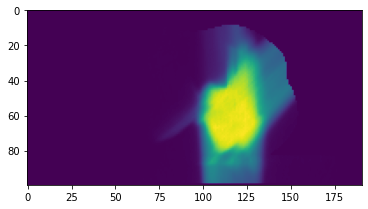

In [51]:
plt.imshow(CT_images[0][50])

In [15]:
image_data['Patient ID']

KeyError: '"Patient ID" not in meta-data dictionary'

In [5]:
CT_images[0].shape

(117, 110, 165)

In [33]:
CT_images.shape

(166, 512, 586)

In [31]:
itk_array = itk.GetArrayFromImage(itk.imread(file_path))

In [32]:
itk_array.shape

(166, 512, 586)

In [2]:
file = pyd.read_file("/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209/1.3.6.1.4.1.32722.228.6.36725526625681761397802081573539292769.dcm")

In [110]:
file_reader = sk.ImageFileReader()
file_reader.SetFileName("/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209/1.3.6.1.4.1.32722.228.6.36725526625681761397802081573539292769.dcm")
dose = file_reader.Execute()

In [141]:
list(dose.GetOrigin())[::-1]

[-612.3, -329.3209, -326.5289]

In [116]:
float(dose.GetMetaData('3004|000e'))

0.0009521339

In [127]:
mypath = "/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209"
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath)]

In [128]:
onlyfiles

['/Users/wangyangwu/Documents/Maastro/NeuralNets/sample/P0439C0006I1473766/RTDOSE/1.3.6.1.4.1.32722.228.6.334797647287977966709364212462384620209/1.3.6.1.4.1.32722.228.6.36725526625681761397802081573539292769.dcm']

In [142]:
np.ceil(-1.3)

-1.0

In [155]:
y = 50
range(y,0,-1)

range(50, 0, -1)

In [164]:
from functools import reduce
l = list(map(lambda x:x-1 if(x>40) else 1000, range(y,0,-1)))

In [165]:
min(l)

40